In [1]:
import awkward as ak
import ROOT 
import numpy as np
import uproot

In [ ]:
Events = ak.from_parquet("AllDatasets.parquet")
M40_17_MC = Events[Events["dataset"] == "M40_RunIISummer20UL17NanoAODv9"]
Pile_up_MC = M40_17_MC["pu_true"]

In [14]:
Pile_up_MC

<Array [[20, 39, 31, 26, 19, ..., 50, 46, 54, 38, 38]] type='1 * var * float64'>

In [8]:
np.array(Pile_up_MC)[0]

array([20., 39., 31., ..., 54., 38., 38.])

In [3]:
# --- Step 1: Load Data PU histogram ---
data_pu_file = "/eos/user/b/bbapi/CMSSW_14_0_15/src/pileup_histos/pileup_2017_Golden.root"
with uproot.open(data_pu_file) as f:
    data_vals, bin_edges = f["pileup"].to_numpy()

# Normalize to probability distribution
data_pdf = data_vals / np.sum(data_vals)

# --- Step 2: Build MC PU distribution from events ---
# mc_nTrueInt comes from MC NanoAOD (Pileup.nTrueInt)
mc_nTrueInt = np.array(Pile_up_MC)[0]

mc_vals, _ = np.histogram(mc_nTrueInt, bins=bin_edges)
mc_pdf = mc_vals / np.sum(mc_vals)

# --- Step 3: Compute PU weights per bin ---
eps = 1e-8
pu_weights_per_bin = np.where(mc_pdf > eps, data_pdf / mc_pdf, 0.0)

# --- Step 4: Assign per-event PU weight ---
bin_idx = np.digitize(mc_nTrueInt, bin_edges) - 1
bin_idx = np.clip(bin_idx, 0, len(pu_weights_per_bin)-1)
pu_weight = pu_weights_per_bin[bin_idx]

# --- Step 5: Combine with genWeight ---
final_weight = pu_weight



/tmp/bbapi/ipykernel_756755/2928006486.py:18: RuntimeWarning: divide by zero encountered in divide
  pu_weights_per_bin = np.where(mc_pdf > eps, data_pdf / mc_pdf, 0.0)


In [10]:
final_weight

array([0.9687471 , 1.06549582, 1.02044347, ..., 1.17408732, 1.06955123,
       1.06955123])

/tmp/bbapi/ipykernel_756755/2583787550.py:12: RuntimeWarning: divide by zero encountered in divide
  pu_weights_per_bin = np.where(mc_pdf > eps, data_pdf / mc_pdf, 0.0)


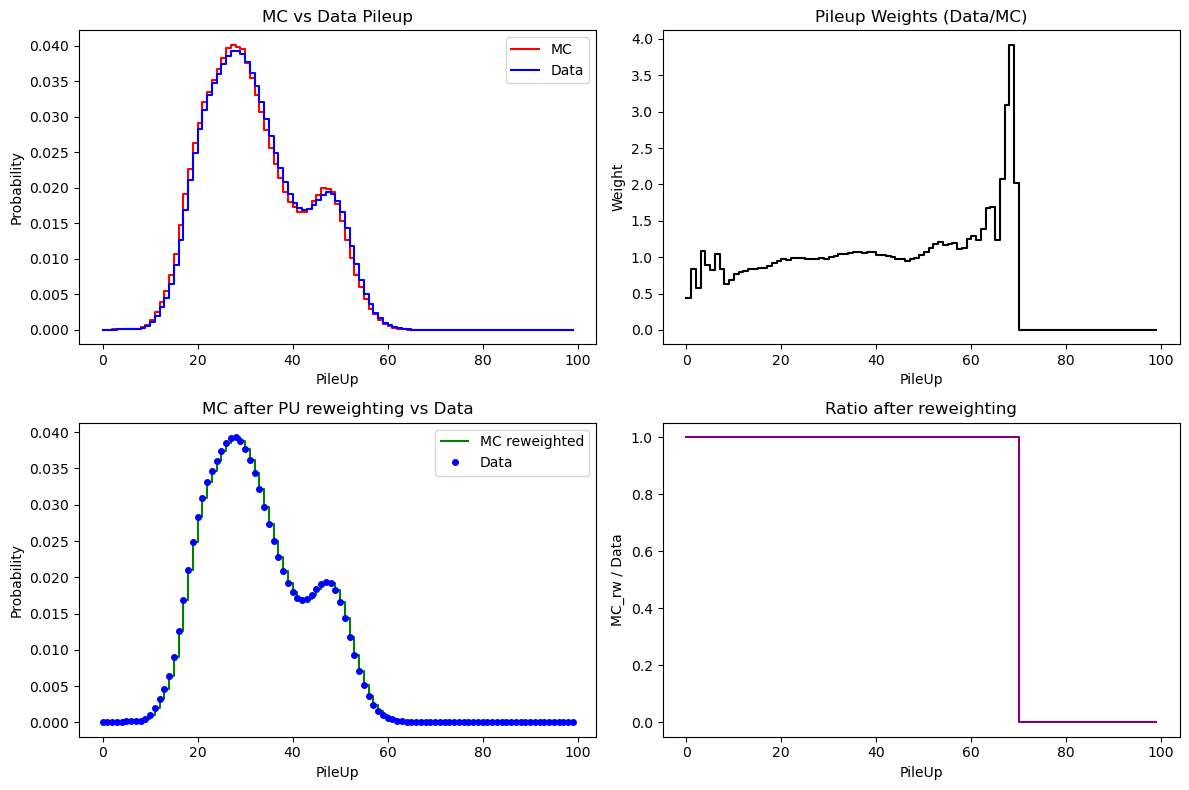

In [4]:
import matplotlib.pyplot as plt

# 1. MC pileup histogram (normalized)
mc_vals, _ = np.histogram(mc_nTrueInt, bins=bin_edges)
mc_pdf = mc_vals / np.sum(mc_vals)

# 2. Data pileup histogram (normalized)
data_pdf = data_vals / np.sum(data_vals)

# 3. PU weights (ratio)
eps = 1e-8
pu_weights_per_bin = np.where(mc_pdf > eps, data_pdf / mc_pdf, 0.0)

# 4. MC pileup after reweighting
# Apply PU weight to each MC event and histogram
bin_idx = np.digitize(mc_nTrueInt, bin_edges) - 1
bin_idx = np.clip(bin_idx, 0, len(pu_weights_per_bin)-1)
pu_weight = pu_weights_per_bin[bin_idx]

mc_vals_rw, _ = np.histogram(mc_nTrueInt, bins=bin_edges, weights=pu_weight)
mc_pdf_rw = mc_vals_rw / np.sum(mc_vals_rw)

# --- Plot ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Top-left: MC vs Data pileup
axes[0, 0].step(bin_edges[:-1], mc_pdf, where='post', label='MC', color='red')
axes[0, 0].step(bin_edges[:-1], data_pdf, where='post', label='Data', color='blue')
axes[0, 0].set_xlabel('PileUp')
axes[0, 0].set_ylabel('Probability')
axes[0, 0].set_title('MC vs Data Pileup')
axes[0, 0].legend()

# Top-right: PU Weights
axes[0, 1].step(bin_edges[:-1], pu_weights_per_bin, where='post', color='black')
axes[0, 1].set_xlabel('PileUp')
axes[0, 1].set_ylabel('Weight')
axes[0, 1].set_title('Pileup Weights (Data/MC)')

# # Bottom-left: MC after reweighting vs Data
# axes[1, 0].step(bin_edges[:-1], mc_pdf_rw, where='post', label='MC reweighted', color='green')
# axes[1, 0].step(bin_edges[:-1], data_pdf, where='post', label='Data', color='blue')
# axes[1, 0].set_xlabel('nTrueInt')
# axes[1, 0].set_ylabel('Probability')
# axes[1, 0].set_title('MC after PU reweighting vs Data')
# axes[1, 0].legend()

axes[1, 0].step(bin_edges[:-1], mc_pdf_rw, where='post', label='MC reweighted', color='green')
axes[1, 0].plot(bin_edges[:-1], data_pdf, 'o', color='blue', label='Data', markersize=4)
axes[1, 0].set_xlabel('PileUp')
axes[1, 0].set_ylabel('Probability')
axes[1, 0].set_title('MC after PU reweighting vs Data')
axes[1, 0].legend()

# Bottom-right: Weight ratio MC_rw / Data (sanity check)
ratio_rw = np.where(data_pdf > eps, mc_pdf_rw / data_pdf, 0)
axes[1, 1].step(bin_edges[:-1], ratio_rw, where='post', color='purple')
axes[1, 1].set_xlabel('PileUp')
axes[1, 1].set_ylabel('MC_rw / Data')
axes[1, 1].set_title('Ratio after reweighting')

plt.tight_layout()
plt.show()


In [21]:
fname = "merged_M25_17.root"
with uproot.open(fname, timeout=120) as Hfile:
    print(Hfile.keys())
    Tree = Hfile["Events"]  # can access TTrees by name
    events = Tree.arrays(library="ak", how="zip")


['tag;2', 'tag;1', 'Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']


In [5]:
fields = events.fields

[s for s in fields if "gen" in s]

['genWeight', 'genTtbarId']

In [6]:
events["genWeight"]

<Array [1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1] type='840000 * float32'>

In [9]:
events.Photon.pt[0]

<Array [84.8, 34.3, 12.7] type='3 * float32'>

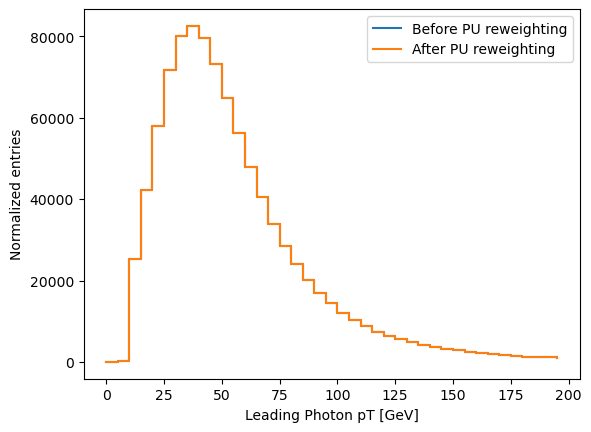

In [57]:
import numpy as np
import awkward as ak

# Leading photon pt (None if no photon)
leading_photon_pt = ak.firsts(events.Photon.pt)

# Mask for events with at least 1 photon
mask = ~ak.is_none(leading_photon_pt)

base_weight = np.sign(ak.to_numpy(events.genWeight))
# len(base_weight)

# Convert to NumPy *after* masking
photon_pt = ak.to_numpy(leading_photon_pt[mask])
base_weight_masked = ak.to_numpy(base_weight[mask])
# base_weight_masked
# len(pu_weight)
pu_weight_masked   = ak.to_numpy(pu_weight[mask])

# Histogram bins
bins = np.linspace(0, 200, 41)  # 5 GeV bins

# Histograms
hist_noPU, _ = np.histogram(photon_pt, bins=bins, weights=base_weight_masked)
hist_PU,   _ = np.histogram(photon_pt, bins=bins, weights=base_weight_masked * pu_weight_masked)

# Normalize for shape comparison
# hist_noPU = hist_noPU / hist_noPU.sum()
# hist_PU   = hist_PU / hist_PU.sum()

# Plot
import matplotlib.pyplot as plt
plt.step(bins[:-1], hist_noPU, where='post', label='Before PU reweighting')
plt.step(bins[:-1], hist_PU, where='post', label='After PU reweighting')
plt.xlabel('Leading Photon pT [GeV]')
plt.ylabel('Normalized entries')
# plt.yscale("log")
plt.legend()
# plt.ylim(0.087, 0.088)
plt.show()



In [53]:
len(base_weight_masked * pu_weight_masked)

953922

In [23]:
pu_weight_masked

array([0.9687471 , 1.06549582, 1.02044347, ..., 0.95199572, 1.06955123,
       1.06955123])

In [24]:
base_weight_masked

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [ ]:
mask

<Array [True, True, True, True, ..., True, True, True] type='840000 * bool'>

In [ ]:
# import numpy as np
# import awkward as ak
# import uproot
# import ROOT

# # --- Config ---
# parquet_file = "AllDatasets.parquet"
# data_pu_file = "/eos/user/b/bbapi/CMSSW_14_0_15/src/pileup_histos/pileup_2017_Golden.root"
# output_root = "PUPlots_2017.root"

# # Load events
# Events = ak.from_parquet(parquet_file)

# # Filter UL17 datasets
# mask = np.char.find(ak.to_numpy(Events["dataset"]), "UL17") >= 0
# Events_2017 = Events[mask]
# mass_points = sorted(set(ak.to_numpy(Events_2017["dataset"])))

# # Load Data pileup histogram
# with uproot.open(data_pu_file) as f:
#     data_vals, bin_edges = f["pileup"].to_numpy()
# data_pdf = data_vals / np.sum(data_vals)

# # Open ROOT output file
# fout = ROOT.TFile(output_root, "RECREATE")

# for mass in mass_points:
#     print(f"Processing: {mass}")

#     # Select events for this dataset
#     M_MC = Events_2017[ak.to_numpy(Events_2017["dataset"]) == mass]
#     mc_nTrueInt = ak.to_numpy(ak.flatten(M_MC["pu_true"]))

#     # MC pileup histogram (normalized)
#     mc_vals, _ = np.histogram(mc_nTrueInt, bins=bin_edges)
#     mc_pdf = mc_vals / np.sum(mc_vals)

#     # PU weights
#     eps = 1e-8
#     pu_weights_per_bin = np.where(mc_pdf > eps, data_pdf / mc_pdf, 0.0)

#     # MC after reweighting
#     bin_idx = np.digitize(mc_nTrueInt, bin_edges) - 1
#     bin_idx = np.clip(bin_idx, 0, len(pu_weights_per_bin) - 1)
#     pu_weight = pu_weights_per_bin[bin_idx]
#     mc_vals_rw, _ = np.histogram(mc_nTrueInt, bins=bin_edges, weights=pu_weight)
#     mc_pdf_rw = mc_vals_rw / np.sum(mc_vals_rw)

#     # Ratio after reweighting
#     ratio_rw = np.where(data_pdf > eps, mc_pdf_rw / data_pdf, 0)

#     # Create histograms
#     h_mc = ROOT.TH1F("h_mc", "", len(bin_edges)-1, bin_edges)
#     h_data = ROOT.TH1F("h_data", "", len(bin_edges)-1, bin_edges)
#     h_weights = ROOT.TH1F("h_weights", "", len(bin_edges)-1, bin_edges)
#     h_mc_rw = ROOT.TH1F("h_mc_rw", "", len(bin_edges)-1, bin_edges)
#     h_ratio = ROOT.TH1F("h_ratio", "", len(bin_edges)-1, bin_edges)

#     for i in range(len(mc_pdf)):
#         h_mc.SetBinContent(i+1, mc_pdf[i])
#         h_data.SetBinContent(i+1, data_pdf[i])
#         h_weights.SetBinContent(i+1, pu_weights_per_bin[i])
#         h_mc_rw.SetBinContent(i+1, mc_pdf_rw[i])
#         h_ratio.SetBinContent(i+1, ratio_rw[i])

#     # --- Create Canvases ---
#     # 1. MC vs Data pileup
#     c1 = ROOT.TCanvas(f"c_mc_data_{mass}", f"MC vs Data Pileup - {mass}", 800, 600)
#     h_mc.SetLineColor(ROOT.kRed)
#     h_mc.Draw("HIST")
#     h_data.SetLineColor(ROOT.kBlue)
#     h_data.Draw("HIST SAME")
#     leg1 = ROOT.TLegend(0.6, 0.7, 0.88, 0.88)
#     leg1.AddEntry(h_mc, "MC", "l")
#     leg1.AddEntry(h_data, "Data", "l")
#     leg1.Draw()

#     # 2. PU Weights
#     c2 = ROOT.TCanvas(f"c_weights_{mass}", f"PU Weights - {mass}", 800, 600)
#     h_weights.SetLineColor(ROOT.kBlack)
#     h_weights.Draw("HIST")

#     # # 3. MC after reweighting vs Data
#     # c3 = ROOT.TCanvas(f"c_mc_rw_data_{mass}", f"MC after PU Reweighting - {mass}", 800, 600)
#     # h_mc_rw.SetLineColor(ROOT.kGreen+2)
#     # h_mc_rw.Draw("HIST")
#     # h_data.SetLineColor(ROOT.kBlue)
#     # h_data.Draw("HIST SAME")
#     # leg3 = ROOT.TLegend(0.6, 0.7, 0.88, 0.88)
#     # leg3.AddEntry(h_mc_rw, "MC reweighted", "l")
#     # leg3.AddEntry(h_data, "Data", "l")
#     # leg3.Draw()

#     # 3. MC after reweighting vs Data
#     c3 = ROOT.TCanvas(f"c_mc_rw_data_{mass}", f"MC after PU Reweighting - {mass}", 800, 600)

#     # MC reweighted → solid green line
#     h_mc_rw.SetLineColor(ROOT.kGreen+2)
#     h_mc_rw.SetLineWidth(2)
#     h_mc_rw.Draw("HIST")

#     # Data → blue points with error bars
#     h_data.SetMarkerStyle(20)      # filled circle
#     h_data.SetMarkerSize(1.0)
#     h_data.SetMarkerColor(ROOT.kBlue)
#     h_data.SetLineColor(ROOT.kBlue)  # keep same for error bars
#     h_data.Draw("P SAME")

#     # Legend
#     leg3 = ROOT.TLegend(0.6, 0.7, 0.88, 0.88)
#     leg3.AddEntry(h_mc_rw, "MC reweighted", "l")
#     leg3.AddEntry(h_data, "Data", "p")
#     leg3.Draw()


#     # 4. Ratio after reweighting
#     c4 = ROOT.TCanvas(f"c_ratio_{mass}", f"Ratio MC_rw/Data - {mass}", 800, 600)
#     h_ratio.SetLineColor(ROOT.kMagenta)
#     h_ratio.Draw("HIST")

#     # --- Write canvases to file ---
#     fout.cd()
#     c1.Write()
#     c2.Write()
#     c3.Write()
#     c4.Write()

# fout.Close()
# print(f"Saved all PU plots for all 2017 mass points in {output_root}")

import numpy as np
import awkward as ak
import uproot
import ROOT

# --- Config ---
parquet_file = "AllDatasets.parquet"
data_pu_files = {
    "2016": "/eos/user/b/bbapi/CMSSW_14_0_15/src/pileup_histos/pileup_2016_Golden.root",
    "2017": "/eos/user/b/bbapi/CMSSW_14_0_15/src/pileup_histos/pileup_2017_Golden.root",
    "2018": "/eos/user/b/bbapi/CMSSW_14_0_15/src/pileup_histos/pileup_2018_Golden.root",
}
output_root = "PUPlots_AllYears.root"

ROOT.TH1.SetDefaultSumw2(True)  # Proper error handling for histograms

# Load events once
Events = ak.from_parquet(parquet_file)

# Open ROOT output file once
fout = ROOT.TFile(output_root, "RECREATE")

for year, data_pu_file in data_pu_files.items():
    print(f"\n=== Processing {year} ===")

    # Filter datasets for this year
    mask = np.char.find(ak.to_numpy(Events["dataset"]), f"UL{year}") >= 0
    mask = np.char.find(ak.to_numpy(Events["dataset"]), "UL17") >= 0
    Events_year = Events[mask]
    mass_points = sorted(set(ak.to_numpy(Events_year["dataset"])))

    # Load Data pileup histogram
    with uproot.open(data_pu_file) as f:
        data_vals, bin_edges = f["pileup"].to_numpy()
    data_pdf = data_vals / np.sum(data_vals)

    # Create directory for this year in the output ROOT file
    fout.mkdir(year)
    fout.cd(year)

    for mass in mass_points:
        print(f"  → {mass}")

        # Select events for this dataset
        M_MC = Events_year[ak.to_numpy(Events_year["dataset"]) == mass]
        mc_nTrueInt = ak.to_numpy(ak.flatten(M_MC["pu_true"]))

        # MC pileup histogram (normalized)
        mc_vals, _ = np.histogram(mc_nTrueInt, bins=bin_edges)
        mc_pdf = mc_vals / np.sum(mc_vals)

        # PU weights
        eps = 1e-8
        pu_weights_per_bin = np.where(mc_pdf > eps, data_pdf / mc_pdf, 0.0)

        # MC after reweighting
        bin_idx = np.digitize(mc_nTrueInt, bin_edges) - 1
        bin_idx = np.clip(bin_idx, 0, len(pu_weights_per_bin) - 1)
        pu_weight = pu_weights_per_bin[bin_idx]
        mc_vals_rw, _ = np.histogram(mc_nTrueInt, bins=bin_edges, weights=pu_weight)
        mc_pdf_rw = mc_vals_rw / np.sum(mc_vals_rw)

        # Ratio after reweighting
        ratio_rw = np.where(data_pdf > eps, mc_pdf_rw / data_pdf, 0)

        # Unique histogram names — detached from ROOT directories
        h_mc = ROOT.TH1F(f"h_mc_{mass}", "", len(bin_edges)-1, bin_edges)
        h_mc.SetDirectory(0)
        h_data = ROOT.TH1F(f"h_data_{mass}", "", len(bin_edges)-1, bin_edges)
        h_data.SetDirectory(0)
        h_weights = ROOT.TH1F(f"h_weights_{mass}", "", len(bin_edges)-1, bin_edges)
        h_weights.SetDirectory(0)
        h_mc_rw = ROOT.TH1F(f"h_mc_rw_{mass}", "", len(bin_edges)-1, bin_edges)
        h_mc_rw.SetDirectory(0)
        h_ratio = ROOT.TH1F(f"h_ratio_{mass}", "", len(bin_edges)-1, bin_edges)
        h_ratio.SetDirectory(0)

        for i in range(len(mc_pdf)):
            h_mc.SetBinContent(i+1, mc_pdf[i])
            h_data.SetBinContent(i+1, data_pdf[i])
            h_weights.SetBinContent(i+1, pu_weights_per_bin[i])
            h_mc_rw.SetBinContent(i+1, mc_pdf_rw[i])
            h_ratio.SetBinContent(i+1, ratio_rw[i])

        # Write histograms
        fout.cd(year)
        h_mc.Write()
        h_data.Write()
        h_weights.Write()
        h_mc_rw.Write()
        h_ratio.Write()

        # --- Create Canvases ---
        # 1. MC vs Data pileup
        c1 = ROOT.TCanvas(f"c_mc_data_{mass}", f"MC vs Data Pileup - {mass}", 800, 600)
        h_mc.SetLineColor(ROOT.kRed)
        h_mc.SetLineWidth(2)
        h_mc.Draw("HIST")
        h_data.SetMarkerStyle(20)
        h_data.SetMarkerSize(1.0)
        h_data.SetMarkerColor(ROOT.kBlue)
        h_data.SetLineColor(ROOT.kBlue)
        h_data.Draw("EP SAME")
        leg1 = ROOT.TLegend(0.6, 0.7, 0.88, 0.88)
        leg1.AddEntry(h_mc, "MC", "l")
        leg1.AddEntry(h_data, "Data", "p")
        leg1.Draw()
        c1.Update()
        c1.Write()

        # 2. PU Weights
        c2 = ROOT.TCanvas(f"c_weights_{mass}", f"PU Weights - {mass}", 800, 600)
        h_weights.SetLineColor(ROOT.kBlack)
        h_weights.SetLineWidth(2)
        h_weights.Draw("HIST")
        c2.Update()
        c2.Write()

        # 3. MC after reweighting vs Data
        c3 = ROOT.TCanvas(f"c_mc_rw_data_{mass}", f"MC after PU Reweighting - {mass}", 800, 600)
        h_mc_rw.SetLineColor(ROOT.kGreen+2)
        h_mc_rw.SetLineWidth(2)
        h_mc_rw.Draw("HIST")
        h_data.Draw("EP SAME")
        leg3 = ROOT.TLegend(0.6, 0.7, 0.88, 0.88)
        leg3.AddEntry(h_mc_rw, "MC reweighted", "l")
        leg3.AddEntry(h_data, "Data", "p")
        leg3.Draw()
        c3.Update()
        c3.Write()

        # 4. Ratio after reweighting
        c4 = ROOT.TCanvas(f"c_ratio_{mass}", f"Ratio MC_rw/Data - {mass}", 800, 600)
        h_ratio.SetLineColor(ROOT.kMagenta)
        h_ratio.SetLineWidth(2)
        h_ratio.Draw("HIST")
        c4.Update()
        c4.Write()

fout.Close()
print(f"\nSaved PU plots and histograms for 2016, 2017, and 2018 in {output_root}")








=== Processing 2016 ===

=== Processing 2017 ===

=== Processing 2018 ===

Saved PU plots and histograms for 2016, 2017, and 2018 in PUPlots_AllYears.root
